# Distance vs Duration

## Import files

In [262]:
import os
import logging
import pandas as pd
import numpy as np
import glob

BASIC_PATH = '../Data/'
ALL_FILES = BASIC_PATH + '*.csv'

def readOneFile(url):
    return pd.read_csv(url, index_col = 0)

data = readOneFile(BASIC_PATH + "flights_2010_9.csv")
print("Aantal records om te beginnen:", len(data))
data = pd.DataFrame(data=data, columns=["airline", "date", "departure_schedule", "arrival_schedule", "distance", "duration", "speed", "departure_airport", "arrival_airport"])

Aantal records om te beginnen: 1000000


## Tranform schedules

In [263]:
import math
from datetime import datetime

FMT = '%H:%M'
def toDateTime(time):
    return datetime.strptime(time, FMT)

def getTotalMinutes(time):
    time_str = str(time).rjust(4, "0")
    hours = time_str[:-2]
    if hours == "24":
        hours = "00"
    minutes = time_str[-2:]
    time_str = hours + ":" + minutes
    return toDateTime(time_str)

data["departure_schedule"] = data["departure_schedule"].map(getTotalMinutes)
data["arrival_schedule"] = data["arrival_schedule"].map(getTotalMinutes)

## Calculate duration

In [265]:
from datetime import timedelta

durations = []
for i, row in data.iterrows():
    arrival = row["arrival_schedule"]
    departure = row["departure_schedule"]
    if arrival <= departure:
        arrival += timedelta(days=1)
    tdelta = arrival - departure
    durations.append(tdelta)

data["duration"] = durations

## Calculate speed

In [266]:
speeds = []
for i, row in data.iterrows():
    duration = row["duration"]
    speed = row["distance"] / ((duration.total_seconds() / 60) / 60)
    speeds.append(speed)

data["speed"] = speeds

## Cleanup

In [273]:
filtered_data = data

shortest_distance_in_us = 100 #KM
longest_distance_in_us = 9000 #KM
shortest_duration_in_us = timedelta(minutes=16)
longest_duration_in_us = timedelta(hours=11, minutes=40)

filtered_data = filtered_data[filtered_data.distance.between(shortest_distance_in_us, longest_distance_in_us)]
filtered_data = filtered_data[filtered_data.duration.between(shortest_duration_in_us,longest_duration_in_us)]
print(len(filtered_data))

987200


In [275]:
filtered_data.describe()

,distance,duration,speed
count,987200.000000,987200,987200.000000
mean,1251.779845,0 days 02:14:29.294064,592.510782
std,949.973642,0 days 01:33:37.694164,376.578934
min,106.750449,0 days 00:16:00,75.191908
25%,563.729527,0 days 01:15:00,379.876261
50%,971.422661,0 days 01:45:00,464.862169
75%,1606.885820,0 days 02:44:00,610.170247
max,8008.106778,0 days 11:35:00,5080.767540


In [277]:
filtered_data.sort_values(by='speed', ascending=False)

,airline,date,departure_schedule,arrival_schedule,distance,duration,speed,departure_airport,arrival_airport
9257208,YV,2012-08-30,1900-01-01 21:30:00,1900-01-01 21:46:00,1354.871344,00:16:00,5080.767540,SAT,PHX
9312329,YV,2012-09-03,1900-01-01 21:30:00,1900-01-01 21:46:00,1354.871344,00:16:00,5080.767540,SAT,PHX
9256917,YV,2012-08-30,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9101125,YV,2012-08-20,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9133094,YV,2012-08-22,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9023002,YV,2012-08-15,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9055840,YV,2012-08-17,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9241004,YV,2012-08-29,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9039414,YV,2012-08-16,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX
9149427,YV,2012-08-23,1900-01-01 15:30:00,1900-01-01 15:47:00,1400.785084,00:17:00,4943.947356,AUS,PHX


In [220]:
test_data = data[data["distance"] > 7000]
test_data = test_data[test_data["airline"] == "HA"]
test_data.sort_values(by='distance', ascending=False)

,airline,date,departure_schedule,arrival_schedule,distance,duration,speed,departure_airport,arrival_airport
9014374,HA,2012-08-15,1900-01-01 15:05:00,1900-01-01 06:55:00,8008.106778,-1 days +15:50:00,505.775165,HNL,JFK
9641760,HA,2012-09-25,1900-01-01 10:00:00,1900-01-01 15:00:00,8008.106778,05:00:00,1601.621356,JFK,HNL
9749822,HA,2012-11-02,1900-01-01 15:05:00,1900-01-01 06:55:00,8008.106778,-1 days +15:50:00,505.775165,HNL,JFK
9733539,HA,2012-11-01,1900-01-01 10:00:00,1900-01-01 15:00:00,8008.106778,05:00:00,1601.621356,JFK,HNL
9733512,HA,2012-11-01,1900-01-01 15:05:00,1900-01-01 06:55:00,8008.106778,-1 days +15:50:00,505.775165,HNL,JFK
9717823,HA,2012-09-30,1900-01-01 10:00:00,1900-01-01 15:00:00,8008.106778,05:00:00,1601.621356,JFK,HNL
9717784,HA,2012-09-30,1900-01-01 15:10:00,1900-01-01 06:55:00,8008.106778,-1 days +15:45:00,508.451224,HNL,JFK
9703991,HA,2012-09-29,1900-01-01 10:00:00,1900-01-01 15:00:00,8008.106778,05:00:00,1601.621356,JFK,HNL
9703960,HA,2012-09-29,1900-01-01 15:10:00,1900-01-01 06:55:00,8008.106778,-1 days +15:45:00,508.451224,HNL,JFK
9689385,HA,2012-09-28,1900-01-01 10:00:00,1900-01-01 15:00:00,8008.106778,05:00:00,1601.621356,JFK,HNL


## Plot

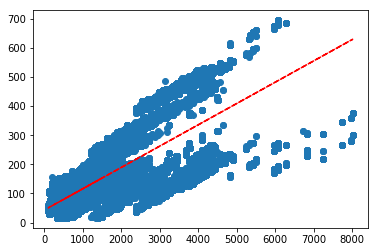

In [276]:
import matplotlib.pyplot as plt

plot_data = filtered_data

x = plot_data['distance']
y = plot_data['duration'].map(lambda tdelta: tdelta.total_seconds() / 60)
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()